# FWI template

## Import modules

In [1]:
# Basic stuff
import sys
sys.path.append("/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/lib/python/")
import genericIO
import SepVector
import Hypercube
import Acoustic_iso_double
import numpy as np
import time

# Solver library
import pyOperator as pyOp
import pyNLCGsolver as NLCG
import pyProblem as Prblm
import pyStopperBase as Stopper
from sys_util import logger

# Plotting library
import matplotlib.pyplot as plt
import sepPlot

## Wavelet

In [2]:
!Wavelet n1=1000 d1=0.008 fund=6. tdelay=1.0 wavelet=ricker2 | Add scale=-1.0 > wlt.H
!Spectra < wlt.H | Graph grid=y max1=30.0 | Xtpen 

## Velocity models

In [3]:
# True velocity model
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=velocityMarmousi.H data=velocityMarmousi.pad.H

# Background velocity model
!Smooth rect1=5 rect2=5 < velocityMarmousi.H > velocityMarmousiStart.H
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=velocityMarmousiStart.H data=velocityMarmousiStart.pad.H

 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 
 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Generate data

### Initialize nonlinear operator

In [4]:
# Note: you need a "dummy arg" for the first argument to replace what would be the executable
args=["dummy arg","vel=velocityMarmousi.pad.H","model=wlt.H","par=parPythonTest.p","sources=wlt.H","nGpu=8"]
modelDouble,dataDouble1,velDouble,parObject,sourcesVector,receiversVector=Acoustic_iso_double.nonlinearOpInitDouble(args)

# Printing parameter file for reference
!cat parPythonTest.p

nts=1000
dts=0.008
sub=8
nz=570
nx=1914
zPadMinus=100
zPadPlus=110
xPadMinus=100
xPadPlus=104
dz=0.01
dx=0.01
fMax=20
zSource=2
xSource=1
nShot=170
spacingShots=10
depthReceiver=2
nReceiver=1700
dReceiver=1
oReceiver=1
saveWavefield=0
wavefieldShotNumber=0
blockSize=16
fat=5
nGpu=8


### Create nonlinear object

In [5]:
nonlinearOp=Acoustic_iso_double.nonlinearPropShotsGpu(modelDouble,dataDouble1,velDouble,parObject,sourcesVector,receiversVector)

### Read wavelet

In [6]:
modelFile=parObject.getString("sources")
modelFloat=genericIO.defaultIO.getVector(modelFile,ndims=3)
modelDMat=modelDouble.getNdArray()
modelSMat=modelFloat.getNdArray()
modelDMat[:]=modelSMat

### Alternate constructor (velocity is the input)

In [7]:
# Clone data vector
dataDouble2=dataDouble1.clone()

# Construct operator
nonlinearVeclocityOp=Acoustic_iso_double.nonlinearVelocityPropShotsGpu(velDouble,dataDouble2,modelDouble,parObject,sourcesVector,receiversVector)

### Nonlinear forward (generate seismic data)

In [8]:
# Conventional nonlinear operator
nonlinearOp.forward(False,modelDouble,dataDouble1);

# "Velocity" nonlinear operator
nonlinearVeclocityOp.forward(False,velDouble,dataDouble2);


### Plot data with conventional nonlinear operator

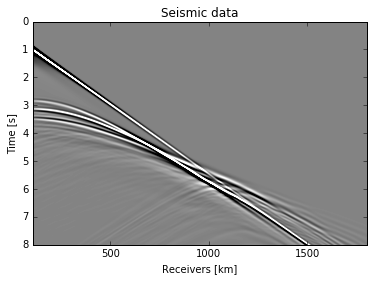

In [11]:
# Convert data to 2D float 
dataFloat2D=SepVector.getSepVector(Hypercube.hypercube(axes=[dataDouble1.getHyper().axes[0],dataDouble1.getHyper().axes[1]]))
dataFloat2DNd=dataFloat2D.getNdArray()
dataDoubleNd=dataDouble1.getNdArray()
dataFloat2DNd[:]=dataDoubleNd[0,:,:]

# Plot forward
sepPlot.Grey(plt,dataFloat2D,label1="Time [s]",label2="Receivers [km]",title="Seismic data").output()

### Plot data with "velocity" nonlinear operator

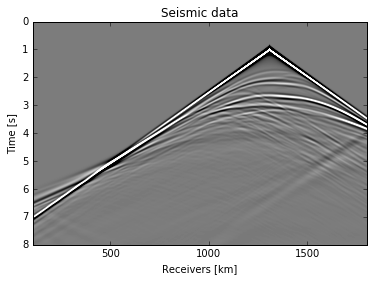

In [13]:
# Convert data to 2D float 
dataVelFloat2D=SepVector.getSepVector(Hypercube.hypercube(axes=[dataDouble2.getHyper().axes[0],dataDouble2.getHyper().axes[1]]))
dataVelFloat2DNd=dataVelFloat2D.getNdArray()
dataDouble2Nd=dataDouble2.getNdArray()
dataVelFloat2DNd[:]=dataDouble2Nd[120,:,:]

# Plot forward
sepPlot.Grey(plt,dataVelFloat2D,label1="Time [s]",label2="Receivers [km]",title="Seismic data").output()

# Start inversion

### Read starting model

In [14]:
# Read starting velocity model
modelStartFwiFloat=genericIO.defaultIO.getVector("velocityMarmousiStart.pad.H",ndims=2)
modelStartFwiFloatNd=modelStartFwiFloat.getNdArray()

# Convert to double
modelStartFwiDouble=SepVector.getSepVector(modelStartFwiFloat.getHyper(),storage="dataDouble")
modelStartFwiDoubleNd=modelStartFwiDouble.getNdArray()
modelStartFwiDoubleNd[:]=modelStartFwiFloatNd

### Initialize Born operator

In [15]:
args=["dummy arg","vel=velocityMarmousiStart.pad.H","sources=wlt.H","par=parPythonTest.p","model=velocityMarmousiStart.pad.H"]
_,_,_,_,_,sourcesSignalsVector,_=Acoustic_iso_double.BornOpInitDouble(args)

### Construct Born

In [16]:
BornOp=Acoustic_iso_double.BornShotsGpu(modelStartFwiDouble,dataDouble1,modelStartFwiDouble,parObject,sourcesVector,sourcesSignalsVector,receiversVector)

### Construct FWI nonlinear operator

In [17]:
FwiOp=pyOp.NonLinearOperator(nonlinearVeclocityOp,BornOp,BornOp.setVel)

### Construct FWI problem

In [18]:
# Create L2-norm nonlinear problem
L2Prob = Prblm.ProblemL2NonLinear(modelStartFwiDouble,dataDouble1,FwiOp)

# Create stopper
niter=10
Stop=Stopper.BasicStopper(niter=niter)

# Create solver
NLCGsolver = NLCG.NLCGsolver(Stop,logger=logger("fwiTemplate.log"))
NLCGsolver.setDefaults(iter_buffer=None)

# Run solver
NLCGsolver.run(L2Prob)

NON-LINEAR CONJUGATE-GRADIENT SOLVER log file
Conjugate method used: FR 
Restart folder: /tmp/restart_2019-01-16T14-09-24.155234/

iter = 0 obj = 5.614368525858185e-07 residual norm = 0.0010596574284136295 gradient norm= 1.5920848284167732e-07 feval = 2
iter = 1 obj = 4.691072990042416e-07 residual norm = 0.0009686147677712142 gradient norm= 1.5920848284167732e-07 feval = 6
iter = 2 obj = 3.5262503990005515e-07 residual norm = 0.000839791726320982 gradient norm= 1.0336787426012961e-07 feval = 10
iter = 3 obj = 2.8836698397206565e-07 residual norm = 0.0007594299968332052 gradient norm= 5.961712190583057e-08 feval = 14
iter = 4 obj = 2.722258082427591e-07 residual norm = 0.0007378696464002132 gradient norm= 6.118575868185872e-08 feval = 18
iter = 5 obj = 2.2944536635620393e-07 residual norm = 0.0006774147623218596 gradient norm= 4.568579115016291e-08 feval = 22
iter = 6 obj = 1.9976326479024105e-07 residual norm = 0.0006320811226032674 gradient norm= 5.117628631978732e-08 feval = 26
iter

In [19]:
invertedModel=L2Prob.model.clone()

## Write inverted model to disk

In [21]:
# Data 
invertedModelFloat=SepVector.getSepVector(invertedModel.getHyper(),storage="dataFloat")
invertedModelFloatNd=invertedModelFloat.getNdArray()
invertedModelNd=invertedModel.getNdArray()
invertedModelFloatNd[:]=invertedModelNd
_=genericIO.defaultIO.writeVector("fwiInvertedModel.H",invertedModelFloat)